In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
import math
%matplotlib inline

In [2]:
filename = './data/train.csv'
train_data_ = pd.read_csv(filename)
train_data_.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [3]:
filename = './data/impermium_verification_labels.csv'
test_data_ = pd.read_csv(filename)
test_data_.head()

,id,Insult,Date,Comment,Usage
0,1,0,20120603163526Z,"""like this if you are a tribe fan""",PrivateTest
1,2,1,20120531215447Z,"""you're idiot.......................""",PrivateTest
2,3,1,20120823164228Z,"""I am a woman Babs, and the only ""war on women...",PrivateTest
3,4,1,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...",PrivateTest
4,5,1,20120602223825Z,"""haha green me red you now loser whos winning ...",PrivateTest


In [6]:
test_data_ = test_data_.drop('id', axis=1)
test_data_ = test_data_.drop('Usage', axis=1)
test_data_.head()

,Insult,Date,Comment
0,0,20120603163526Z,"""like this if you are a tribe fan"""
1,1,20120531215447Z,"""you're idiot......................."""
2,1,20120823164228Z,"""I am a woman Babs, and the only ""war on women..."
3,1,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F..."
4,1,20120602223825Z,"""haha green me red you now loser whos winning ..."


In [7]:
filename = './data/test_with_solutions.csv'
valid_data_ = pd.read_csv(filename)
valid_data_.head()

,Insult,Date,Comment,Usage
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...",PublicTest
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ...",PublicTest
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ...",PublicTest
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou...",PrivateTest
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ...",PrivateTest


In [8]:
def data_preprocessing(data):
    max_sym_len = 0
    max_word_len = 0
    lens_in_words = []

    for i, comment in enumerate(data['Comment']):
        data.iloc[i,2] = data.iloc[i,2].lower()
        data.iloc[i,2] = re.sub('n\'t', ' not', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'m', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'s', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'re', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'ve', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'d', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' im ', ' i', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' ur ', ' you ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\? ', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[!?]+', ' mysignssymbol ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(r'href=[\'"]?([^\'" >]+)', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[^a-z]+', ' ', data.iloc[i,2]) # replace everything not lowercase literals with space
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        for letter in string.ascii_lowercase: #replace multiple letters (3 and more) 
            data.iloc[i,2] = re.sub(letter * 3 + '+', letter,  data.iloc[i,2] ).strip() 
        data.iloc[i,2] = re.sub('mysignssymbol', '<SIGNS>', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        if max_sym_len < len(comment):
            max_sym_len = len(comment)
        if max_word_len < len(comment.split(' ')):
            max_word_len = len(comment.split(' '))
        lens_in_words.append(len(comment.split(' ')))
        
    print ('Max comment length in symbols:', max_sym_len)
    print ('Max comment length in words:  ', max_word_len)
    plt.plot(np.arange(len(lens_in_words)), np.asarray(lens_in_words))
    plt.xlabel('Comment')
    plt.ylabel('Length in words')
    return data

Max comment length in symbols: 17805
Max comment length in words:   2407
Max comment length in symbols: 1437
Max comment length in words:   224
Max comment length in symbols: 20030
Max comment length in words:   1419


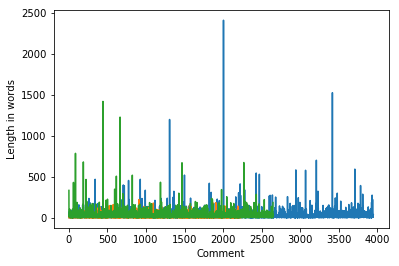

In [9]:
train_data = data_preprocessing(train_data_)
test_data = data_preprocessing(test_data_)
valid_data = data_preprocessing(valid_data_)

In [10]:
def write_input_file_fasttext(data, name):
    f = open(name + '.txt', 'w')
    for i in range(data.shape[0]):
        if name == 'train' or name == 'valid':
            f.write('__label__' + str(data.iloc[i,0]) + " " +  data.iloc[i,2] + '\n')
        elif name == 'test':
            f.write(data.iloc[i,2] + '\n')
        else:
            print ('Incorrect data name')
    f.close()

### For fasttext input

In [11]:
write_input_file_fasttext(train_data, name='train')
write_input_file_fasttext(valid_data, name='valid')
write_input_file_fasttext(test_data, name='test')

In [12]:
train_data.to_csv('./data/prepr_train.csv', index=False)
valid_data.to_csv('./data/prepr_valid.csv', index=False)
test_data.to_csv('./data/prepr_test.csv', index=False)